Наш продукт — мобільний застосунок з моделлю підписок, на якому ми запустили монетизаційний A/B тест, в якому тестували альтернативну підписку

 `control` — користувачам пропонувалась місячна підписка за $5.99 з триденним пробним періодом

 `treatment` — користувачам пропонувалась тижнева підписка за $2.99 з триденним пробним періодом

Тест проводили протягом тижня на локаціях з Tier-1: Австралія, Велика Британія, США та Канада.

**Завдання:**

1. Проаналізуй результати A/B тесту, використовуючи зручний інструмент та прикріпи аналіз до тестового у вигляді файлу
2. Підготуй для команди продактів мініпрезентацію про результати тесту з висновками та пропозиціями, як діяти далі.

In [1]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/ТЗ /ТЗ KissMyApps/KMA TestTask Product Analyst - Task1.csv', parse_dates=['install_date'])

In [2]:
df.head(5)

,user_id,install_date,country,test_group,trial,paid,subscription_name,revenue_1m
0,0000dd3fa4702a63d1b76aaffe1ab39b,2023-06-05,US,treatment,0,0,NaN,0.0
1,0001f27ab7e22228e54c8b2028b43f24,2023-06-07,AU,treatment,0,0,NaN,0.0
2,0006c5c547801308b36ea3cf669856ae,2023-06-07,AU,treatment,0,0,NaN,0.0
3,000d1a300263c5db91cbefa3852898a7,2023-06-07,AU,control,0,0,NaN,0.0
4,000e5e62e8746e467ed9f49ac5de3208,2023-06-06,US,treatment,0,0,NaN,0.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15285 entries, 0 to 15284
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            15285 non-null  object        
 1   install_date       15285 non-null  datetime64[ns]
 2   country            15285 non-null  object        
 3   test_group         15285 non-null  object        
 4   trial              15285 non-null  int64         
 5   paid               15285 non-null  int64         
 6   subscription_name  1723 non-null   object        
 7   revenue_1m         15285 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 955.4+ KB


In [4]:
#відберу тільки точно потрібні країни
tier1 = ['AU', 'GB', 'US', 'CA']
df = df[df['country'].isin(tier1)]

In [5]:
df.shape
df['country'].value_counts()

,count
country,
CA,3895
GB,3837
US,3790
AU,3763


**Сформуємо гіпотези:**

* **Для trial conversion rate:**

Нульова гіпотеза (H0): частка користувачів, які активували trial, однакова в обох групах.

Альтернативна гіпотеза (H1): частки різні (тобто нова підписка впливає на trial rate).

* **Для paid conversion rate:**

Нульова гіпотеза (H0): частка користувачів, які оформили платну підписку після trial, однакова в обох групах.

Альтернативна гіпотеза (H1): частки різні.

In [6]:
group_stats = df.groupby('test_group').agg({
    'user_id': 'count',
    'trial': 'mean',
    'paid': 'mean',
    'revenue_1m': ['mean', 'sum']
}).reset_index()

group_stats.columns = ['test_group', 'users', 'trial_rate', 'paid_rate', 'ARPU', 'total_revenue']

display(group_stats)

,test_group,users,trial_rate,paid_rate,ARPU,total_revenue
0,control,7627,0.121280,0.015209,0.091103,694.84
1,treatment,7658,0.104205,0.019457,0.103467,792.35


Поки бачимо, що `paid_rate` та `ARPU` виглядають краще в `treatment` групі.
Потрібно перевірити статистично значущість цієї різниці.

In [7]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [8]:
results_trial = df.groupby('test_group')['trial'].sum()
results_paid = df.groupby('test_group')['paid'].sum()

n_trial = df.groupby('test_group')['trial'].count()
n_paid = df.groupby('test_group')['paid'].count()

z_trial, p_trial = proportions_ztest(count=results_trial, nobs=n_trial)
z_paid, p_paid = proportions_ztest(count=results_paid, nobs=n_paid)

ci_trial_low, ci_trial_up = proportion_confint(count=results_trial, nobs=n_trial, alpha=0.05)
ci_paid_low, ci_paid_up = proportion_confint(count=results_paid, nobs=n_paid, alpha=0.05)

print(f'Trial z = {z_trial:.2f}, p = {p_trial:.4f}')
print(f'Paid  z = {z_paid:.2f}, p = {p_paid:.4f}\n')

print(f'Довірчий інтервал 95% для trial (control):   [{ci_trial_low.iloc[0]:.3f}, {ci_trial_up.iloc[0]:.3f}]')
print(f'Довірчий інтервал 95% для trial (treatment): [{ci_trial_low.iloc[1]:.3f}, {ci_trial_up.iloc[1]:.3f}]')

print(f'Довірчий інтервал 95% для paid (control):    [{ci_paid_low.iloc[0]:.3f}, {ci_paid_up.iloc[0]:.3f}]')
print(f'Довірчий інтервал 95% для paid (treatment):  [{ci_paid_low.iloc[1]:.3f}, {ci_paid_up.iloc[1]:.3f}]')

Trial z = 3.34, p = 0.0008
Paid  z = -2.01, p = 0.0443

Довірчий інтервал 95% для trial (control):   [0.114, 0.129]
Довірчий інтервал 95% для trial (treatment): [0.097, 0.111]
Довірчий інтервал 95% для paid (control):    [0.012, 0.018]
Довірчий інтервал 95% для paid (treatment):  [0.016, 0.023]


**Що отримали:**

* **Для trial conversion rate:**

z = 3.34, p = 0.0008 -  **різниця статистично значуща** (бо p < 0.05).

CI не перетинаються.

У treatment групі менше людей активували trial (гірше)

* **Для paid conversion rate:**

z = -2.01, p = 0.0443 - **різниця також статистично значуща**.

CI не перетинаються.

У treatment групі більше людей оплатили підписку після trial (краще)


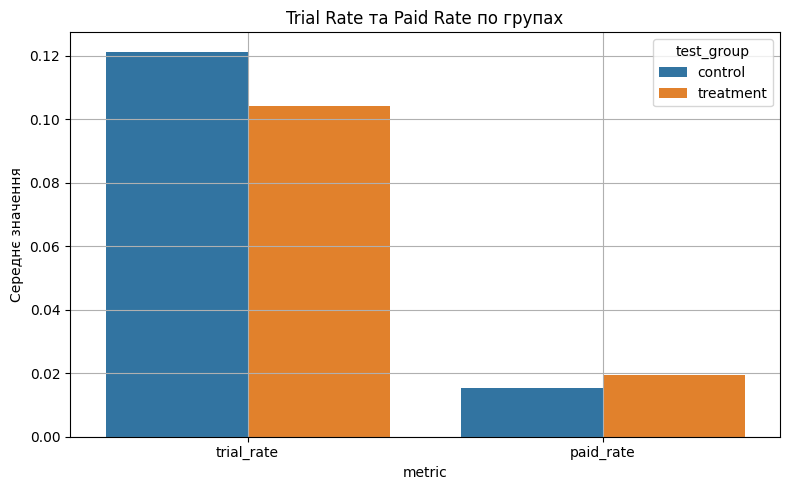

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

rates = df.groupby('test_group').agg(
    trial_rate=('trial', 'mean'),
    paid_rate=('paid', 'mean')
).reset_index().melt(id_vars='test_group', var_name='metric', value_name='rate')


plt.figure(figsize=(8, 5))
sns.barplot(data=rates, x='metric', y='rate', hue='test_group')
plt.title('Trial Rate та Paid Rate по групах')
plt.ylabel('Середнє значення')
plt.grid(True)
plt.tight_layout()
plt.show();

**Сформуємо гіпотезу ARPU (revenue_1m):**

* Нульова гіпотеза (H0): середній дохід на користувача однаковий

* Альтернативна гіпотеза (H1): середній дохід різний


In [10]:
from scipy.stats import ttest_ind

control_revenue = df[df['test_group'] == 'control']['revenue_1m']
treatment_revenue = df[df['test_group'] == 'treatment']['revenue_1m']

t_stat, p_val = ttest_ind(control_revenue, treatment_revenue, equal_var=False)

print(f"T-test ARPU: t = {t_stat:.3f}, p = {p_val:.4f}")

T-test ARPU: t = -0.977, p = 0.3285


Ми не можемо відхилити нульову гіпотезу, бо p > 0.05.

Тобто немає статистично значущої різниці в ARPU між control і treatment.

У середньому користувач з новою підпискою не приносив більше доходу, ніж зі старою (принаймні, на 1 місяць).

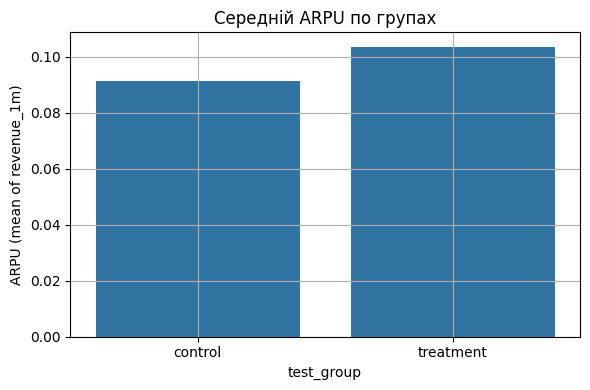

In [11]:
arpu_df = df.groupby('test_group')['revenue_1m'].mean().reset_index()

plt.figure(figsize=(6, 4))
sns.barplot(data=arpu_df, x='test_group', y='revenue_1m')
plt.title('Середній ARPU по групах')
plt.ylabel('ARPU (mean of revenue_1m)')
plt.grid(True)
plt.tight_layout()
plt.show();

**Перейдемо до аналізу по країнам:**

In [12]:
country_stats = df.groupby(['country', 'test_group']).agg({
    'user_id': 'count',
    'trial': 'mean',
    'paid': 'mean',
    'revenue_1m': ['mean', 'sum']
}).reset_index()

country_stats.columns = ['country', 'test_group', 'users', 'trial_rate', 'paid_rate', 'ARPU', 'total_revenue']
display(country_stats)

,country,test_group,users,trial_rate,paid_rate,ARPU,total_revenue
0,AU,control,1928,0.118257,0.015560,0.093205,179.70
1,AU,treatment,1835,0.104087,0.021253,0.114060,209.30
2,CA,control,1936,0.113120,0.009298,0.055692,107.82
3,CA,treatment,1959,0.106177,0.018887,0.094630,185.38
4,GB,control,1846,0.146262,0.018960,0.113570,209.65
5,GB,treatment,1991,0.104972,0.020593,0.111130,221.26
6,US,control,1917,0.108503,0.017214,0.103114,197.67
7,US,treatment,1873,0.101442,0.017085,0.094186,176.41


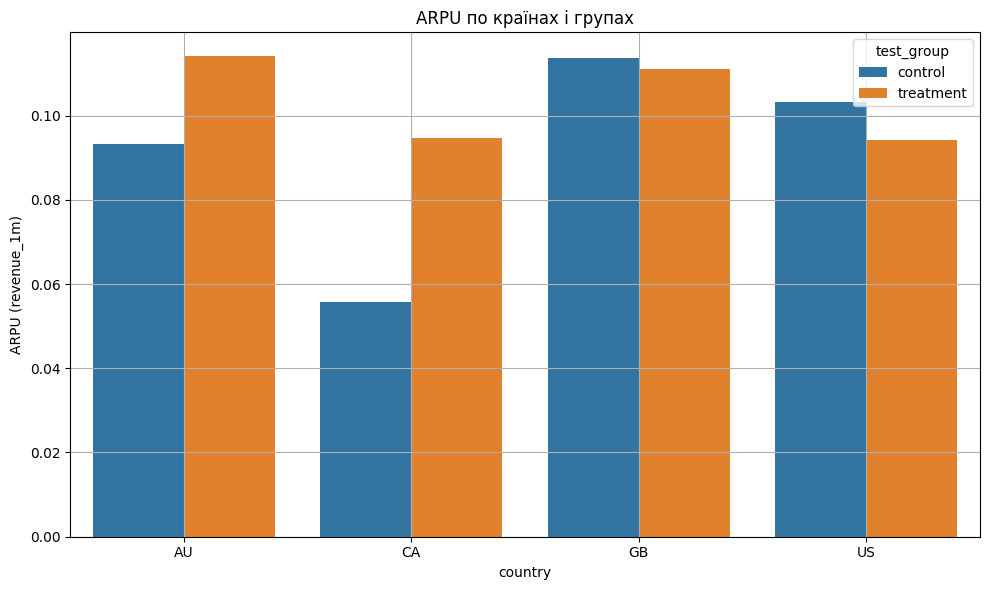

In [13]:
plt.figure(figsize=(10, 6))
sns.barplot(data=country_stats, x='country', y='ARPU', hue='test_group')
plt.title('ARPU по країнах і групах')
plt.ylabel('ARPU (revenue_1m)')
plt.grid(True)
plt.tight_layout()
plt.show();

In [14]:
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind

countries = ['AU', 'CA', 'GB', 'US']

for country in countries:
    df_c = df[df['country'] == country]

    # Trial Z-test
    trial_success = df_c.groupby('test_group')['trial'].sum()
    trial_total = df_c.groupby('test_group')['trial'].count()
    z_trial, p_trial = proportions_ztest(trial_success, trial_total)

    # Paid Z-test
    paid_success = df_c.groupby('test_group')['paid'].sum()
    paid_total = df_c.groupby('test_group')['paid'].count()
    z_paid, p_paid = proportions_ztest(paid_success, paid_total)

    # ARPU T-test
    control = df_c[df_c['test_group'] == 'control']['revenue_1m']
    treatment = df_c[df_c['test_group'] == 'treatment']['revenue_1m']
    t_stat, p_arpu = ttest_ind(control, treatment, equal_var=False)

    print(f"{country} → Trial p = {p_trial:.4f} | Paid p = {p_paid:.4f} | ARPU p = {p_arpu:.4f}")


AU → Trial p = 0.1672 | Paid p = 0.1932 | ARPU p = 0.4334
CA → Trial p = 0.4880 | Paid p = 0.0112 | ARPU p = 0.0723
GB → Trial p = 0.0001 | Paid p = 0.7169 | ARPU p = 0.9285
US → Trial p = 0.4784 | Paid p = 0.9755 | ARPU p = 0.7275


* **Австралія (AU)** — treatment виглядає краще (візуально).

При цьому всі p > 0.05 → різниця не статистично доведена.

**Висновок:** Можна продовжити тестування або запускати з обережністю.


---

* **Канада (CA)** — єдиний сегмент, де treatment показав великий розрив (візуально).

Paid p = 0.0112 - платна конверсія краща у treatment
ARPU p = 0.0723 — можна постежити ще.

**Висновок:** можна запускати treatment.


---

* **Велика Британія (GB)** — візуально різниці немає.

Trial rate значно вищий у control (p = 0.0001).
ARPU і paid rate — без значущих змін.

**Висновок:** Treatment неефективний. Control виграє.


---

* **США (US):** - візуально трішки різниця є.

Але жодна з метрик не показала статистичної різниці.

**Висновок:** Treatment немає ефекту.